# **OPTIMIZATION HOMEWORK**

|Surname   |Name     |Badge Nr.|
|--------- |---------|---------|
| Lazzari  | Tommaso | 2159017 |
| Safa     | Nasser  | 2134777 |
|Ludergnani| Brenno  | 2142931 |
| Movila   | Dumitru | 2144565 |

# **DATA GENERATION**

In [ ]:
U = 280 #number of unlabeled data points
L = 120 #number of labeled data points

import numpy as np

#random seed for reproducibility
np.random.seed(77)

#generation of random points uniformly in [0,1]^2
points = np.random.rand(U + L, 2)

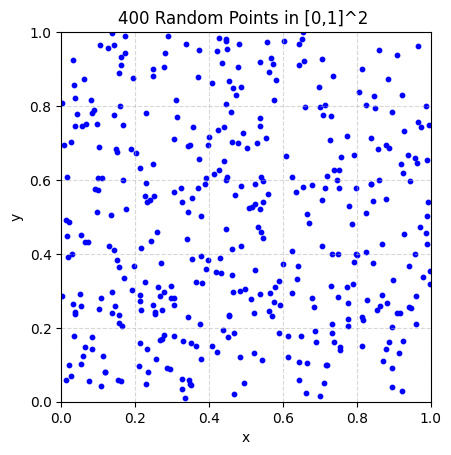

In [ ]:
import matplotlib.pyplot as plt
#plot the generated data points
plt.scatter(points[:, 0], points[:, 1], color='blue', s=10)
plt.title('400 Random Points in [0,1]^2 ')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The following code is aimed to label the 30% of the data and to visualize it

In [ ]:
#split the dataset
labeled_points = points[:L]
unlabeled_points = points[L:]
#label a portion of the data points

#generate random binary labels
labels = np.random.randint(0, 2, size=(L, 1))
#and append them to the now labeled dataset
labeled_points = np.hstack((labeled_points, labels))

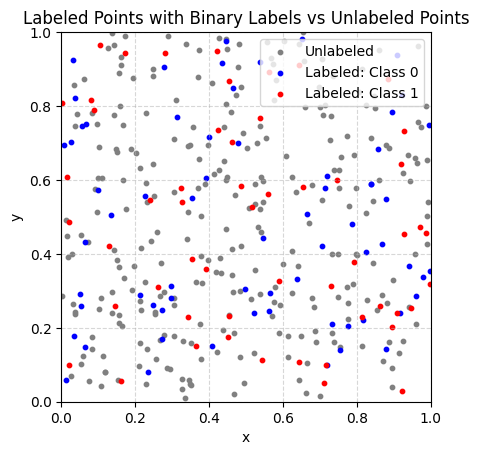

In [ ]:
#plot
plt.scatter(unlabeled_points[:, 0], unlabeled_points[:, 1], color='gray', s=10, label='Unlabeled')
plt.scatter(labeled_points[labeled_points[:, 2] == 0][:, 0], labeled_points[labeled_points[:, 2] == 0][:, 1],
            color='blue', s=10, label='Labeled: Class 0')
plt.scatter(labeled_points[labeled_points[:, 2] == 1][:, 0], labeled_points[labeled_points[:, 2] == 1][:, 1],
            color='red', s=10, label='Labeled: Class 1')
plt.title('Labeled Points with Binary Labels vs Unlabeled Points')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# **WEIGHT COMPUTATION**

In [ ]:
#WEIGHTS W (similarity measure between labeled and unlabeled data points)

from scipy.spatial.distance import cdist

#compute the distance matrix between labeled (rows) and unlabeled (columns) data
#each element w_ij of the matrix will be the euclidean distance between the i-th labeled data point and j-th unlabeled data point
labeled_coords = labeled_points[:, :2]
W = cdist(labeled_coords, unlabeled_points, metric='euclidean')
W = W / W.max()
W = 1 - W


print("Shape of W:", W.shape)
print("Sample of W:\n", W[:5, :5])  #just to inspect the top-left corner

Shape of W: (120, 280)
Sample of W:
 [[0.4897414  0.85813911 0.50733474 0.35147821 0.38314473]
 [0.45663731 0.49207692 0.82225578 0.21606731 0.50556549]
 [0.835458   0.43869968 0.40204002 0.86782865 0.68763487]
 [0.90193752 0.57140185 0.65561419 0.6491001  0.8203482 ]
 [0.92473529 0.51391701 0.62017968 0.67516139 0.85874313]]


In [ ]:
from scipy.spatial.distance import squareform, pdist

#efficient way to compute an intra-set distance, since distance from A to B, will be the same as from B to A
W_hat = squareform(pdist(unlabeled_points, metric='euclidean'))
W_hat = W_hat / W_hat.max()
W_hat = 1 - W_hat

print("Shape of W_hat:", W_hat.shape)
print("Sample of W_hat:\n", W_hat[:5, :5])



Shape of W_hat: (280, 280)
Sample of W_hat:
 [[1.         0.53946988 0.55361013 0.74127991 0.78504723]
 [0.53946988 1.         0.43244784 0.44957461 0.38823593]
 [0.55361013 0.43244784 1.         0.29603248 0.65644577]
 [0.74127991 0.44957461 0.29603248 1.         0.55695541]
 [0.78504723 0.38823593 0.65644577 0.55695541 1.        ]]


# **LOSS FUNCTION**

In [ ]:
#LOSS FUNCTION

def loss_function(W, W_hat, labeled_labels, y_unlabeled):

    #first term: weighted sum of the differences between labeled and unlabeled data points
    term1 = 0
    for i in range(L):
        for j in range(U):
            diff = y_unlabeled[j] - labeled_labels[i]
            term1 += W[i, j] * (diff ** 2)

    #second term: half weighted sum of the differences between unlabeled data points
    term2 = 0
    for i in range(U):
        for j in range(U):
            diff = y_unlabeled[i] - y_unlabeled[j]
            term2 += W_hat[i, j] * (diff ** 2)

    term2 *= 0.5

    return term1 + term2


In [ ]:
#FIRST DERIVATE OF THE LOSS FUNCTION

def gradient_yj(j, W, W_hat, labeled_labels, y_unlabeled):

    #first term first derivate with respect to y_j
    term1 = 0
    for i in range(L):
        term1 += W[i, j] * (y_unlabeled[j] - labeled_labels[i])

    #second term first derivate with respect to y_j
    term2 = 0
    for i in range(U):
        term2 += W_hat[i, j] * (y_unlabeled[j] - y_unlabeled[i])

    #eturn 2*term1 + term2
    return  2*term1 + 2*term2


# **GRADIENT DESCENT**

Gradient Descent with fixed stepsize

Iteration 0, Loss: 10848.0940, Gradient Norm: 2385.011548
Iteration 50, Loss: 5045.5886, Gradient Norm: 0.038270
Converged at iteration 88


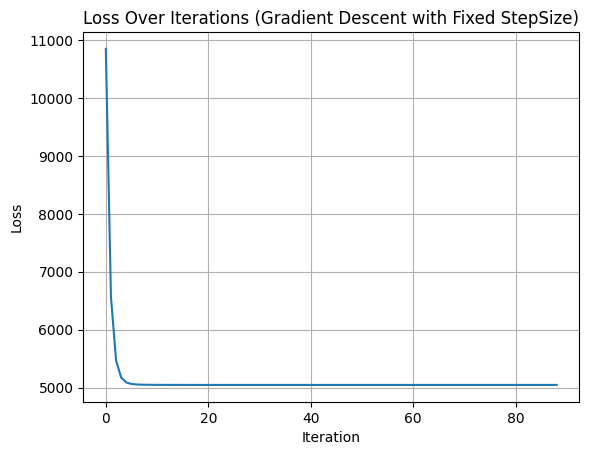

In [ ]:
#(Arbitrary) FIXED STEP SIZE
np.random.seed(77)

# Hyperparameters
alpha = 0.001   # Learning rate (arbitrarily set)
max_iter = 500  # Number of iterations
tolerance = 1e-4  # Stopping criterion

# Initialize y_unlabeled with random values
y_unlabeled = np.random.rand(U)  # U is the number of unlabeled points



# Placeholder for the loss history to track convergence
loss_history = []

# Gradient Descent Loop
for iteration in range(max_iter):
    # Compute current loss
    current_loss = loss_function(W, W_hat, labels.flatten(), y_unlabeled)
    loss_history.append(current_loss)
    # Create empty gradient array (one value per unlabeled point)
    gradients = np.zeros(U)
    # Compute gradients (using the gradient_yj function)
    gradients = np.clip(gradients, -10, 10)  # Clip gradients to a max value

    for j in range(U):
       gradients[j] = gradient_yj(j, W, W_hat, labels.flatten(), y_unlabeled)

    # Update y_unlabeled using gradient descent update rule
    y_unlabeled -= alpha * gradients

    # Check for convergence (based on the gradient norm)
    grad_norm = np.linalg.norm(gradients)
    if grad_norm < tolerance:
        print(f"Converged at iteration {iteration}")
        break

    # Print progress every 50 iterations
    if iteration % 50 == 0:
        print(f"Iteration {iteration}, Loss: {current_loss:.4f}, Gradient Norm: {grad_norm:.6f}")


plt.plot(loss_history)
plt.title("Loss Over Iterations (Gradient Descent with Fixed StepSize)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

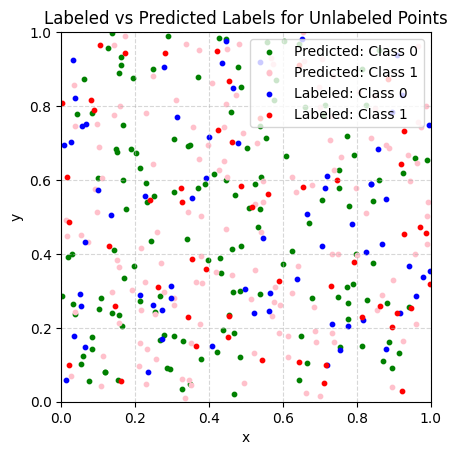

In [ ]:
# Apply thresholding to convert continuous predictions to binary labels
threshold = 0.45
y_unlabeled = np.random.rand(U)  # Predicted values for the unlabeled points (continuous)
predicted_labels = (y_unlabeled >= threshold).astype(int)

# Combine the labeled points and the newly predicted labels for the unlabeled points
final_labeled_points = np.vstack([labeled_points, np.hstack([unlabeled_points, predicted_labels.reshape(-1, 1)])])

# Plot the unlabeled points with their newly assigned predicted labels (0 or 1)
plt.scatter(unlabeled_points[predicted_labels == 0][:, 0], unlabeled_points[predicted_labels == 0][:, 1],
            color='green', s=10, label='Predicted: Class 0')
plt.scatter(unlabeled_points[predicted_labels == 1][:, 0], unlabeled_points[predicted_labels == 1][:, 1],
            color='pink', s=10, label='Predicted: Class 1')

# Also plot the original labeled points for reference
plt.scatter(labeled_points[labeled_points[:, 2] == 0][:, 0], labeled_points[labeled_points[:, 2] == 0][:, 1],
            color='blue', s=10, label='Labeled: Class 0')
plt.scatter(labeled_points[labeled_points[:, 2] == 1][:, 0], labeled_points[labeled_points[:, 2] == 1][:, 1],
            color='red', s=10, label='Labeled: Class 1')

# Adding plot title and labels
plt.title('Labeled vs Predicted Labels for Unlabeled Points')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')

# Adding legend to differentiate between classes
plt.legend()

# Show the grid and plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Estimation of Lipschitz Constant

In [ ]:
#LIPSCHITZ CONSTANT
np.random.seed(77)

#Since our loss function is quadratic and its first derivate is linear (e.g. DL(y) = Ay + b),
#the rate at which the gradient changes is just determined by the matrix multiplying y (A).
#So, how fast does the gradient change? It depends on the largest eigenvalue of A,
#because eigenvalues tell how much the matrix can 'stretch' a vector
        #and in gradient descent we ant to avoid
        #taking steps that overshoot the minimum.
        #If the function has directions where it changes very quickly (big eigenvalues)
        #we need to take smaller steps in those directions
        #(and therefore we use the inverse of Lipschitz constant)
#So, our loss functions has a Lipschitz constant equal to the largest eigenvalue of the matrix multiplying y (A),

#that, in our case, is W^T W + L_hat, with
    #W the already computed weights similarity matrix (between labeled and unlabeled data)
#L_hat = D_hat - W_hat, where
    #W_hat is the already computed similarity matrix (between unlabeled data)
    #D_hat is a diagonal matrix in which each entry is the row sum of W_hat
#this term appears in the second term of the loss function, that, in fact can also be written as y^T L_hat y,
#with the goal of penalizing differences between connected nodes, enforcing smoothness.

#Putting everything together, the loss function can also be written as
  #L(y) = y^T (W^T W + L_hat) y + (linear terms)
  #DL(y) = 2(W^T W + L_hat) y + (constant vector)
#And, therefore:
  #Lipschitz constant = 2 * lambda_max(W^T W + L_hat)

#Graph Laplacian
D_hat = np.diag(W_hat.sum(axis=1))
L_hat = D_hat - W_hat

#Approximation of Lipschitz constant
W_transpose_W = np.dot(W.T, W)
H = 2 * (W_transpose_W + L_hat)
eigvals = np.linalg.eigvalsh(H)
L_lipschitz = np.max(eigvals)

# Use 1 / L as learning rate
alpha_lipschitz = 1.0 / L_lipschitz
print(f"Estimated Lipschitz constant: {L_lipschitz:.4f}, Step size (1/L): {alpha_lipschitz:.6f}")


Estimated Lipschitz constant: 25280.0561, Step size (1/L): 0.000040


Iteration 0, Loss: 10848.0940, Gradient Norm: 2385.011548
Iteration 50, Loss: 5887.4005, Gradient Norm: 894.450088
Iteration 100, Loss: 5178.1169, Gradient Norm: 344.329902
Iteration 150, Loss: 5070.2280, Gradient Norm: 138.440343
Iteration 200, Loss: 5051.8427, Gradient Norm: 60.757979
Iteration 250, Loss: 5047.8997, Gradient Norm: 31.232418
Iteration 300, Loss: 5046.6896, Gradient Norm: 19.255527
Iteration 350, Loss: 5046.1740, Gradient Norm: 13.368512
Converged at iteration 379


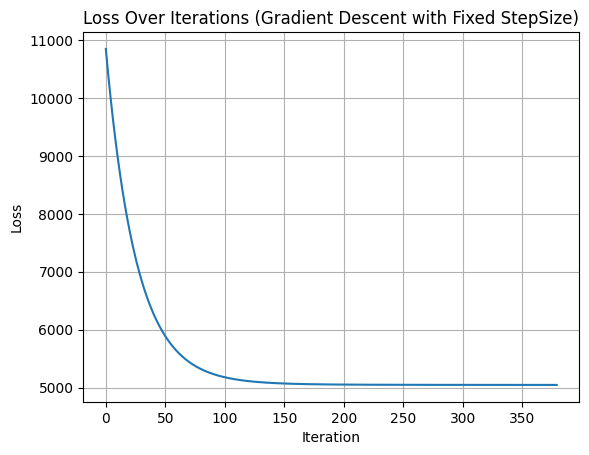

In [ ]:
#(1 / LipschitzConstant) FIXED STEP SIZE
np.random.seed(77)

max_iter = 1500  # Number of iterations
## Stopping criterions
tolerance = 1e-4
min_improvement = 1e-2

# Initialize y_unlabeled with random values
y_unlabeled = np.random.rand(U)  # U is the number of unlabeled points

# Placeholder for the loss history to track convergence
loss_history = []

# Gradient Descent Loop
for iteration in range(max_iter):
    # Compute current loss
    current_loss = loss_function(W, W_hat, labels.flatten(), y_unlabeled)
    loss_history.append(current_loss)
    # Create empty gradient array (one value per unlabeled point)
    gradients = np.zeros(U)
    # Compute gradients (using the gradient_yj function)
    gradients = np.clip(gradients, -10, 10)  # Clip gradients to a max value
    for j in range(U):
        gradients[j] = gradient_yj(j, W, W_hat, labels.flatten(), y_unlabeled)

    # Update y_unlabeled using gradient descent update rule
    y_unlabeled -= alpha_lipschitz * gradients

    # Check for convergence (based on the gradient norm)
    grad_norm = np.linalg.norm(gradients)
    if grad_norm < tolerance:
        print(f"Converged at iteration {iteration}")
        break

    if iteration >3 and (loss_history[-3] - loss_history[-1]) < min_improvement:
        print(f"Converged at iteration {iteration}")
        break


    # Print progress every 50 iterations
    if iteration % 50 == 0:
        print(f"Iteration {iteration}, Loss: {current_loss:.4f}, Gradient Norm: {grad_norm:.6f}")

plt.plot(loss_history)
plt.title("Loss Over Iterations (Gradient Descent with Fixed StepSize)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Armijo Rule Hyperparameters fine tuning

In [ ]:
#ARMIJO RULE HYPERPARAMETERS FINE TUNING

import itertools

max_iter = 500
alpha_init = 1.0

#grid of values
delta_values = [0.3, 0.5, 0.7]   # 0 < delta < 1
gamma_values = [ 1e-3, 1e-2, 0.05, 0.1]  # 0 < gamma < 0.5

results = []

max_m = 50
tolerance = 1e-4

#loop over all possible combinations of delta and gamma included in the grid
for delta, gamma in itertools.product(delta_values, gamma_values):
    np.random.seed(77)

    y_unlabeled = np.random.rand(U)
    loss_history = []

    for iteration in range(max_iter):
        current_loss = loss_function(W, W_hat, labels.flatten(), y_unlabeled)
        loss_history.append(current_loss)

        gradients = np.zeros(U)
        for j in range(U):
            gradients[j] = gradient_yj(j, W, W_hat, labels.flatten(), y_unlabeled)

        d = -gradients
        dot_product = np.dot(gradients, d)

        m = 0
        while True:
            alpha = (delta ** m) * alpha_init
            y_trial = y_unlabeled + alpha * d
            loss_trial = loss_function(W, W_hat, labels.flatten(), y_trial)

            if loss_trial <= current_loss + gamma * alpha * dot_product:
                break
            m += 1
            if m > max_m:
                break

        y_unlabeled += alpha * d
        grad_norm = np.linalg.norm(gradients)

        if grad_norm < tolerance or m > max_m:
            break

    results.append({
        'delta': delta,
        'gamma': gamma,
        'final_loss': loss_history[-1],
        'iterations': iteration,
        'converged': grad_norm < tolerance,
        'final_grad_norm': grad_norm
    })

#sort the results stored in results by their number of iterations
sorted_results = sorted(results, key=lambda x: (not x['converged'], x['iterations']))

for res in sorted_results[:5]:
    print(f"Delta: {res['delta']:.2f}, Gamma: {res['gamma']:.4f}, "
          f"Final Loss: {res['final_loss']:.4f}, Iterations: {res['iterations']}, "
          f"Converged: {res['converged']}")


Delta: 0.50, Gamma: 0.0500, Final Loss: 5045.5886, Iterations: 20, Converged: True
Delta: 0.50, Gamma: 0.0010, Final Loss: 5045.5886, Iterations: 22, Converged: True
Delta: 0.50, Gamma: 0.0100, Final Loss: 5045.5886, Iterations: 22, Converged: True
Delta: 0.50, Gamma: 0.1000, Final Loss: 5045.5886, Iterations: 22, Converged: True
Delta: 0.30, Gamma: 0.0010, Final Loss: 5045.5886, Iterations: 26, Converged: True


Gradient Descent with Armijo Rule

In [ ]:
#ARMIJO RULE
np.random.seed(77)

max_iter = 500           #Number of iterations
alpha_init = 1.0         #initial step size
#hyperparameters fine tuned:
delta = 0.5             #shrinkage base (0 < delta < 1)
gamma = 0.05            #sufficient decrease parameter (0 < gamma < 0.5)

#stopping conditions
max_m = 10
tolerance = 1e-4
max_m_reached = False

#y_unlabeled random values initialization
y_unlabeled = np.random.rand(U)  # U is the number of unlabeled points

# Placeholder for the loss history to track convergence
loss_history = []

for iteration in range(max_iter):
    current_loss = loss_function(W, W_hat, labels.flatten(), y_unlabeled) #computes the loss
    loss_history.append(current_loss) #and appends it in a list where the loss function values will be stored for the whole process, to track the improvements

    gradients = np.zeros(U)
    for j in range(U):
        gradients[j] = gradient_yj(j, W, W_hat, labels.flatten(), y_unlabeled) #compute the gradient of the loss function with respect to each y_unlabeled

    d = -gradients #descent directions
    dot_product = np.dot(gradients, d)

    #now we need to decide the size of the learning rate to compute a step towards the minimum of the loss function, as per the Armijo Rule
    m = 0
    while True:
        alpha = (delta ** m) * alpha_init #set the step size
        y_trial = y_unlabeled + alpha * d #compute the new labels with the just fixed step size
        loss_trial = loss_function(W, W_hat, labels.flatten(), y_trial) #compute the loss function with the just computed labels

        if loss_trial <= current_loss + gamma * alpha * dot_product: #check the step would lead the algorithm to a point in the loss function lower enough to the previous one to justify the step
            break
        m += 1 #otherwise reduce the step size
        if m > max_m:
            print("Stopping: exceeded max_m")
            print(f"Converged at iteration {iteration}, Loss: {current_loss:.4f}")
            max_m_reached = True
            break

    # Update y_unlabeled
    y_unlabeled += alpha * d

    grad_norm = np.linalg.norm(gradients)

    #check for convergence
    if grad_norm < tolerance:
        print(f"Converged at iteration {iteration}, Loss: {current_loss:.4f}")
        break

    if 'max_m_reached' in locals() and max_m_reached:
        break

    # Logging
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {current_loss:.4f}, Gradient Norm: {grad_norm:.6f}, Step Size: {alpha:.5f}, m: {m}")

import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.title("Loss Over Iterations (Gradient Descent with Armijo Rule)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# **BCGD with GS RULE**

In [ ]:
import numpy as np

max_iter = 500          # Number of iterations
# Stopping criterions
tolerance = 1e-4
min_improvement = 6

#hyperparameters
alpha_init = 1.0           # Initial step size
delta = 0.5                # Shrinkage factor (0 < delta < 1)
gamma = 0.05               # Sufficient decrease parameter (0 < gamma < 0.5)
max_m = 10                # Max shrinkage iterations per coordinate

# Initialize y_unlabeled with random values
y_unlabeled = np.random.rand(U)  # U is the number of unlabeled points

# Placeholder to track loss history
loss_history = []

for iteration in range(max_iter):
    current_loss = loss_function(W, W_hat, labels.flatten(), y_unlabeled)
    loss_history.append(current_loss)

    # Compute full gradient vector
    full_gradients = np.array([
        gradient_yj(j, W, W_hat, labels.flatten(), y_unlabeled)
        for j in range(U)
    ])

    # Gauss-Southwell rule: pick the coordinate with the largest |gradient|
    j_star = np.argmax(np.abs(full_gradients))
    gradient = full_gradients[j_star]
    d = -gradient
    m = 0

    # Armijo rule
    while m < max_m:
        step = (delta ** m) * alpha_init
        y_trial = np.copy(y_unlabeled)
        y_trial[j_star] += step * d

        loss_trial = loss_function(W, W_hat, labels.flatten(), y_trial)

        if loss_trial <= current_loss + gamma * step * gradient * d:
            break
        m += 1

    # Update only the selected coordinate
    y_unlabeled[j_star] += (delta ** m) * alpha_init * d

    # Compute gradient norm for convergence check
    grad_norm = np.linalg.norm(full_gradients)

    if grad_norm < tolerance:
        print(f"Converged at iteration {iteration}")
        break

    if iteration > 3 and (loss_history[-3] - loss_history[-1]) < min_improvement:
        print(f"Converged at iteration {iteration}")
        break

    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {current_loss:.4f}, Gradient Norm: {grad_norm:.6f}")

# Plot loss curve
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.title("Loss Over Iterations (BCGD with Armijo + Gauss-Southwell Rule)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# **COORDINATE MINIMIZATION**

In [ ]:
#C - coordinate Way
import numpy as np

# Hyperparameters
alpha = 0.001  # Learning rate
max_iter = 500  # Number of iterations
tolerance = 1e-4  # Stopping criterion

# Initialize y_unlabeled with random values
y_unlabeled = np.random.rand(U)  # U is the number of unlabeled points

# Placeholder for the loss history to track convergence
loss_history = []

# Coordinate Minimization Loop
for iteration in range(max_iter):
    # Compute current loss
    current_loss = loss_function(W, W_hat, labels.flatten(), y_unlabeled)
    loss_history.append(current_loss)

    # Loop over all coordinates (or parameters)
    for j in range(U):
        # Fix all coordinates except y_unlabeled[j]
        # Perform gradient descent to minimize the loss with respect to y_unlabeled[j]
        gradient = gradient_yj(j, W, W_hat, labels.flatten(), y_unlabeled)

        # Update the coordinate y_unlabeled[j] using gradient descent
        y_unlabeled[j] -= alpha * gradient  # Move towards the minimum

    # Check for convergence (if the change in y_unlabeled is very small)
    grad_norm = np.linalg.norm(gradient)  # Norm of the gradient
    if grad_norm < tolerance:
        print(f"Converged at iteration {iteration}")
        break

    # Print progress every 50 iterations
    if iteration % 50 == 0:
        print(f"Iteration {iteration}, Loss: {current_loss:.4f}, Gradient Norm: {grad_norm:.6f}")

# Optional: Plot the loss over iterations for convergence visualization
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.title("Loss Over Iterations (Coordinate Minimization)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Coordinate Minimization GD, Alternative Implementation

In [ ]:
#C - coordinate Way
import numpy as np

# Hyperparameters
alpha = 0.001  # Learning rate
max_iter = 500  # Number of iterations
tolerance = 1e-4  # Stopping criterion

# Initialize y_unlabeled with random values
y_unlabeled = np.random.rand(U)  # U is the number of unlabeled points

# Placeholder for the loss history to track convergence
loss_history = []
y_unlabeled_history = [y_unlabeled.copy()] # Track y_unlabeled for convergence check

print("Starting Coordinate Minimization (Alternative Update)...")

for iteration in range(max_iter):
    y_unlabeled_old = y_unlabeled.copy()

    # Compute current loss before the cycle of updates
    # The loss calculation is correct even with the large W_hat diagonal
    current_loss = loss_function(W, W_hat, labels.flatten(), y_unlabeled)
    loss_history.append(current_loss)

    # --- Cycle through each unlabeled coordinate (y_unlabeled[j]) ---
    for j in range(U):
        sum_W_hat_ju_except_j = np.sum(W_hat[j, :] * y_unlabeled) - W_hat[j, j] * y_unlabeled[j]
        sum_W_hat_j_except_j = np.sum(W_hat[j, :]) - W_hat[j, j]

        numerator = 2*np.sum(W[:, j] * labels.flatten()) + sum_W_hat_ju_except_j
        denominator = 2*np.sum(W[:, j]) + sum_W_hat_j_except_j

        if denominator > epsilon:
             y_unlabeled[j] = numerator / denominator

    # Calculate the maximum absolute change in y_unlabeled across this iteration's cycle
    max_change = np.max(np.abs(y_unlabeled - y_unlabeled_old))
    y_unlabeled_history.append(y_unlabeled.copy()) # Store updated y_unlabeled

    if max_change < tolerance:
        print(f"Converged at iteration {iteration} with max change {max_change:.6f}")
        break

    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {current_loss:.4f}, Max Change: {max_change:.6f}")

if iteration == max_iter - 1:
    print(f"Maximum iterations ({max_iter}) reached.")

print("\nOptimization finished.")
print("Final y_unlabeled values:")
# print(y_unlabeled) # Too many values to print usually

y_pred = (y_unlabeled > 0.7).astype(int) # Changed threshold to 0.5
#print(y_unlabeled)
# Optional: Plot the loss over iterations for convergence visualization
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.title("Loss Over Iterations (Coordinate Minimization)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Try on real datasets


# Try on Datasets


##Breast Cancer Dataset (Winsconsin)

Breast Cancer Dataset Gradient Descent


Iteration 0, Loss: 6340.3237, Gradient Norm: 201.396765
Iteration 10, Loss: 4401.7356, Gradient Norm: 181.937976
Iteration 20, Loss: 3180.4975, Gradient Norm: 154.840700
Iteration 30, Loss: 2503.0603, Gradient Norm: 125.744994
Iteration 40, Loss: 2169.2439, Gradient Norm: 100.796180
Iteration 50, Loss: 1999.6250, Gradient Norm: 84.122902
Iteration 60, Loss: 1926.4457, Gradient Norm: 59.249300
Iteration 70, Loss: 1903.8762, Gradient Norm: 35.440423
Iteration 80, Loss: 1894.9720, Gradient Norm: 23.385150
Iteration 90, Loss: 1890.5302, Gradient Norm: 15.785682
Iteration 100, Loss: 1888.2007, Gradient Norm: 10.723841
Iteration 110, Loss: 1886.9384, Gradient Norm: 7.309634
Iteration 120, Loss: 1886.2306, Gradient Norm: 4.994678
Iteration 130, Loss: 1885.8193, Gradient Norm: 3.419965
Iteration 140, Loss: 1885.5719, Gradient Norm: 2.346163
Iteration 150, Loss: 1885.4184, Gradient Norm: 1.612416
Iteration 160, Loss: 1885.3206, Gradient Norm: 1.110092
Iteration 170, Loss: 1885.2569, Gradient No

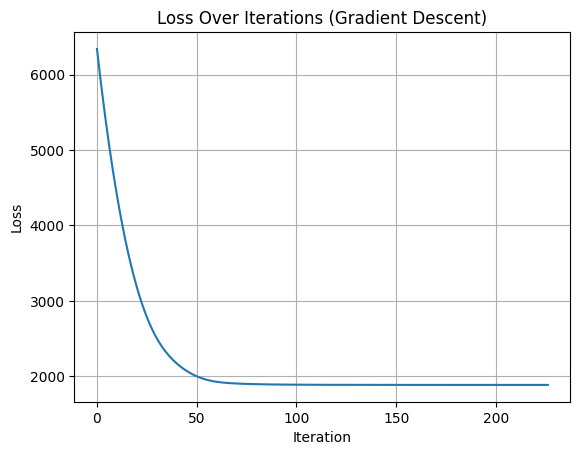

In [ ]:
np.random.seed(77)

#Trying Cancer Dataset with GD

from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, squareform, pdist
import time

cancer = load_breast_cancer()

X=cancer.data
y=cancer.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(
    X, y, test_size=0.8, stratify=y
)

L = len(X_labeled)
U = len(X_unlabeled)

labeled_coords = X_labeled[:, :]
unlabeled_coords = X_unlabeled[:, :]

#Matrices
W = cdist(labeled_coords, unlabeled_coords, metric='euclidean')
W_hat= squareform(pdist(unlabeled_coords, metric='euclidean'))
epsilon = 1e-8

W = 1 / (W + epsilon)
W_hat = 1 / (W_hat + epsilon)




# Initial guess for unlabeled outputs
y_unlabeled = np.random.rand(U)
y_labeled = y_labeled.astype(float)

# === STEP 2: Define the loss function and its gradient ===
def loss_function(W, W_hat, labeled_labels, y_unlabeled):
    term1 = 0
    for i in range(L):
        for j in range(U):
            diff = y_unlabeled[j] - labeled_labels[i]
            term1 += W[i, j] * (diff ** 2)

    term2 = 0
    for i in range(U):
        for j in range(U):
            diff = y_unlabeled[i] - y_unlabeled[j]
            term2 += W_hat[i, j] * (diff ** 2)

    term2 *= 0.5
    return term1 + term2

def gradient_yj(j, W, W_hat, labeled_labels, y_unlabeled):
    term1 = 0
    for i in range(L):
        term1 += W[i, j] * (y_unlabeled[j] - labeled_labels[i])

    term2 = 0
    for i in range(U):
        term2 += W_hat[i, j] * (y_unlabeled[j] - y_unlabeled[i])

    return 2 * term1 + term2


# === STEP 3: Gradient Descent Algorithm ===
alpha = 0.001
max_iter = 500
tolerance = 0.1

loss_history = []

start_time = time.process_time()

for iteration in range(max_iter):
    current_loss = loss_function(W, W_hat, y_labeled, y_unlabeled)
    loss_history.append(current_loss)

    gradients = np.zeros(U)
    for j in range(U):
        gradients[j] = gradient_yj(j, W, W_hat, y_labeled, y_unlabeled)

    gradients = np.clip(gradients, -10, 10)
    y_unlabeled -= alpha * gradients

    grad_norm = np.linalg.norm(gradients)
    if grad_norm < tolerance:
        print(f"Converged at iteration {iteration}")
        break

    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {current_loss:.4f}, Gradient Norm: {grad_norm:.6f}")

end_time = time.process_time()
cpu_time = end_time - start_time

# === STEP 4: Evaluate accuracy ===
y_pred = (y_unlabeled > 0.7).astype(int)
acc = accuracy_score(y_unlabeled_true, y_pred)
print(f"\nAccuracy on unlabeled data: {acc:.4f}")
print(f"CPU time for gradient descent: {cpu_time:.2f} seconds")
print(y_pred)
print(y_unlabeled_true)


# === STEP 5: Plot loss over time ===
plt.plot(loss_history)
plt.title("Loss Over Iterations (Gradient Descent)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Breast Cancer Dataset, Gradient Descent with Armijo Rule

Iteration 0, Loss: 6340.3237, Gradient Norm: 809.789914, Step Size: 0.00781, m: 7
Iteration 10, Loss: 1885.2429, Gradient Norm: 2.345593, Step Size: 0.00781, m: 7
Stopping: exceeded max_m in Armijo rule
Converged at iteration 14, Loss: 1885.1195

Accuracy on unlabeled data: 0.8838
CPU time for gradient descent with Armijo rule: 27.25 seconds
[0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0
 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0
 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0
 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0
 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1
 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1
 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0
 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0
 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0

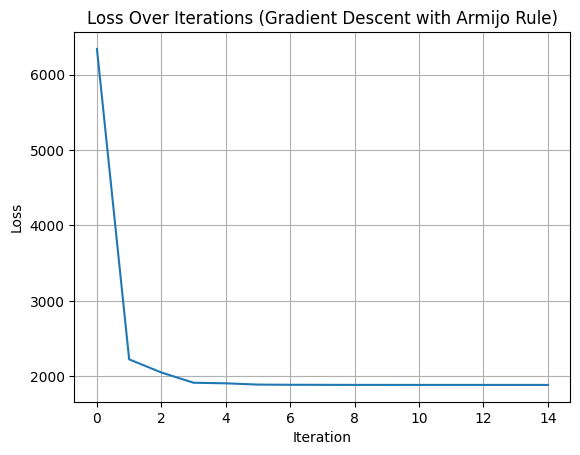

In [ ]:
np.random.seed(77)

#Armijo Rule GD

from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, squareform, pdist

cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(
    X, y, test_size=0.8, stratify=y
)

L = len(X_labeled)
U = len(X_unlabeled)

labeled_coords = X_labeled[:, :]
unlabeled_coords = X_unlabeled[:, :]

#Matrices
W = cdist(labeled_coords, unlabeled_coords, metric='euclidean')
W_hat= squareform(pdist(unlabeled_coords, metric='euclidean'))
epsilon = 1e-8
W = 1 / (W + epsilon)
W_hat = 1 / (W_hat + epsilon)


# Initial guess for unlabeled outputs
y_unlabeled = np.random.rand(U)
y_labeled = y_labeled.astype(float)

max_iter = 500  # Number of iterations
alpha_init = 1.0  # Initial step size

delta = 0.5  # Shrinkage base (0 < delta < 1)
gamma = 0.05  # Sufficient decrease parameter (0 < gamma < 0.5)

# Stopping conditions
max_m = 10
tolerance = 0.1
max_m_reached = False

# Placeholder for the loss history to track convergence
loss_history = []
start_time = time.process_time()

for iteration in range(max_iter):
    current_loss = loss_function(W, W_hat, y_labeled, y_unlabeled)  # Use y_labeled here
    loss_history.append(current_loss)  # Store the loss

    gradients = np.zeros(U)
    for j in range(U):
        gradients[j] = gradient_yj(j, W, W_hat, y_labeled, y_unlabeled)  # Use y_labeled here

    d = -gradients  # Descent directions
    dot_product = np.dot(gradients, d)

    # Armijo rule for step size selection
    m = 0
    while True:
        alpha = (delta ** m) * alpha_init  # Set the step size
        #print(alpha)
        #print(m)
        y_trial = y_unlabeled + alpha * d  # Compute the new labels
        loss_trial = loss_function(W, W_hat, y_labeled, y_trial)  # Use y_labeled here

        if loss_trial <= current_loss + gamma * alpha * dot_product:  # Check Armijo condition
            break
        m += 1  # Reduce the step size
        if m > max_m:
            print("Stopping: exceeded max_m in Armijo rule")
            print(f"Converged at iteration {iteration}, Loss: {current_loss:.4f}")
            max_m_reached = True
            break

    # Update y_unlabeled
    y_unlabeled += alpha * d
    grad_norm = np.linalg.norm(gradients)

    # Check for convergence
    if grad_norm < tolerance:
        print(f"Converged at iteration {iteration}, Loss: {current_loss:.4f}, Gradient Norm: {grad_norm:.6f}")
        break

    if m>max_m:
      break
    if 'max_m_reached' in locals() and max_m_reached:
      print("stopping condition reached")
      break

    # Logging
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {current_loss:.4f}, Gradient Norm: {grad_norm:.6f}, Step Size: {alpha:.5f}, m: {m}")

end_time = time.process_time()  # Record end time
cpu_time = end_time - start_time

# Make predictions on the unlabeled data
y_pred = (y_unlabeled > 0.7).astype(int)

# Evaluate accuracy on the true unlabeled labels
accuracy = accuracy_score(y_unlabeled_true, y_pred)
print(f"\nAccuracy on unlabeled data: {accuracy:.4f}")
print(f"CPU time for gradient descent with Armijo rule: {cpu_time:.2f} seconds")
print(y_pred)
print(y_unlabeled_true)

# Plot loss curve
plt.plot(loss_history)
plt.title("Loss Over Iterations (Gradient Descent with Armijo Rule)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Breast Cancer Dataset with BCDG with Gauss-Southwell Rule

Iteration 0, Loss: 6340.3237, Gradient Norm: 809.789914, Block: 289
Iteration 10, Loss: 6157.9465, Gradient Norm: 789.916929, Block: 237
Iteration 20, Loss: 5937.6077, Gradient Norm: 766.350902, Block: 149
Iteration 30, Loss: 5691.8952, Gradient Norm: 741.317672, Block: 394
Iteration 40, Loss: 5468.0419, Gradient Norm: 716.878641, Block: 62
Iteration 50, Loss: 5304.3848, Gradient Norm: 695.607160, Block: 210
Iteration 60, Loss: 5065.4407, Gradient Norm: 668.249954, Block: 331
Iteration 70, Loss: 4865.4178, Gradient Norm: 643.323290, Block: 345
Iteration 80, Loss: 4666.8011, Gradient Norm: 618.459639, Block: 444
Iteration 90, Loss: 4475.9811, Gradient Norm: 594.143813, Block: 303
Iteration 100, Loss: 4270.6084, Gradient Norm: 569.701074, Block: 173
Iteration 110, Loss: 4079.8566, Gradient Norm: 545.921078, Block: 13
Iteration 120, Loss: 3895.1599, Gradient Norm: 523.656093, Block: 366
Iteration 130, Loss: 3737.5916, Gradient Norm: 502.164537, Block: 346
Iteration 140, Loss: 3589.6819, G

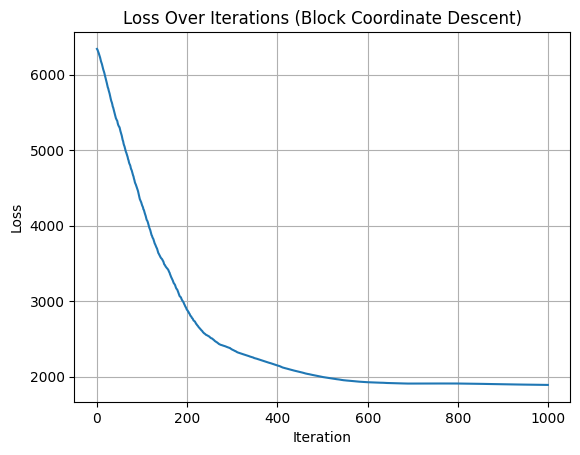

In [ ]:
np.random.seed(77)

#BCGD with Gauss-Southwell Rule

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist, squareform, pdist


# Load and preprocess data (as in your original code)
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(X, y, test_size=0.8, stratify=y)
L = len(X_labeled)
U = len(X_unlabeled)
labeled_coords = X_labeled[:, :]
unlabeled_coords = X_unlabeled[:, :]


#epsilon = 1e-8
#W = 1 / (cdist(labeled_coords, unlabeled_coords) + epsilon)
#W_hat= squareform(pdist(unlabeled_coords, metric='euclidean'))

W = cdist(labeled_coords, unlabeled_coords, metric='euclidean')
W_hat= squareform(pdist(unlabeled_coords, metric='euclidean'))
epsilon = 1e-8
W = 1 / (W + epsilon)
W_hat = 1 / (W_hat + epsilon)


# Initial values
y_unlabeled = np.random.rand(U)
y_labeled = y_labeled.astype(float)


# Block settings
block_size = 1
num_blocks = int(np.ceil(U / block_size))
blocks = [np.arange(i * block_size, min((i + 1) * block_size, U)) for i in range(num_blocks)]
  # Optimization loop
max_iter = 1000
step_size = 0.01
tolerance = 0.1
loss_history = []
start_time = time.process_time()

for iteration in range(max_iter):
    current_loss = loss_function(W, W_hat, y_labeled, y_unlabeled)
    loss_history.append(current_loss)

    #gradients = compute_gradients(W, W_hat, y_labeled, y_unlabeled)
    gradients = np.zeros(U)
    for j in range(U):
        gradients[j] = gradient_yj(j, W, W_hat, y_labeled, y_unlabeled)

      # Gauss-Southwell: pick block with largest gradient norm
    block_norms = [np.linalg.norm(gradients[block]) for block in blocks]
    block_idx = np.argmax(block_norms)
    block_to_update = blocks[block_idx]

      # Update all variables in selected block
    y_unlabeled[block_to_update] -= step_size * gradients[block_to_update]

    grad_norm = np.linalg.norm(gradients)
    if grad_norm < tolerance:
        print(f"Converged at iteration {iteration}, Loss: {current_loss:.4f}, Gradient Norm: {grad_norm:.6f}")
        break

    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {current_loss:.4f}, Gradient Norm: {grad_norm:.6f}, Block: {block_idx}")

end_time = time.process_time()
cpu_time = end_time - start_time
# Evaluation
#print(y_unlabeled)
y_pred = (y_unlabeled > 0.7).astype(int)

accuracy = accuracy_score(y_unlabeled_true, y_pred)
print(f"\nAccuracy on unlabeled data: {accuracy:.4f}")
print(f"CPU time for BCDG with Gauss-Southwell Rule: {cpu_time:.2f} seconds")
print(y_pred)
print(y_unlabeled_true)
# Plot
plt.plot(loss_history)
plt.title("Loss Over Iterations (Block Coordinate Descent)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Starting Coordinate Minimization (Alternative Update)...
Iteration 0, Loss: 6340.3237, Max Change: 0.632216
Iteration 10, Loss: 1885.1287, Max Change: 0.000109
Converged at iteration 14 with max change 0.000005

Optimization finished.
Final y_unlabeled values:
[0.65232521 0.72195373 0.64606805 0.71528242 0.65335155 0.61410233
 0.62954116 0.67416988 0.72823226 0.71799033 0.65610439 0.65027535
 0.73088983 0.72888828 0.72830461 0.72477565 0.64737139 0.72351008
 0.7018809  0.70873351 0.64329642 0.66417912 0.73335663 0.73746644
 0.64246767 0.70831095 0.70482451 0.73055031 0.64948057 0.66507008
 0.70236426 0.72417805 0.6809201  0.63415404 0.73104991 0.61393802
 0.6346762  0.70119495 0.72976721 0.72764078 0.65641411 0.69023906
 0.69685304 0.67691659 0.70614154 0.70940931 0.726773   0.69136949
 0.72719044 0.6209088  0.63845869 0.66089594 0.65448859 0.71177954
 0.62754589 0.69808738 0.71831424 0.72604941 0.67840166 0.61666596
 0.7227745  0.65948578 0.66455612 0.65112326 0.71519516 0.67465677
 0

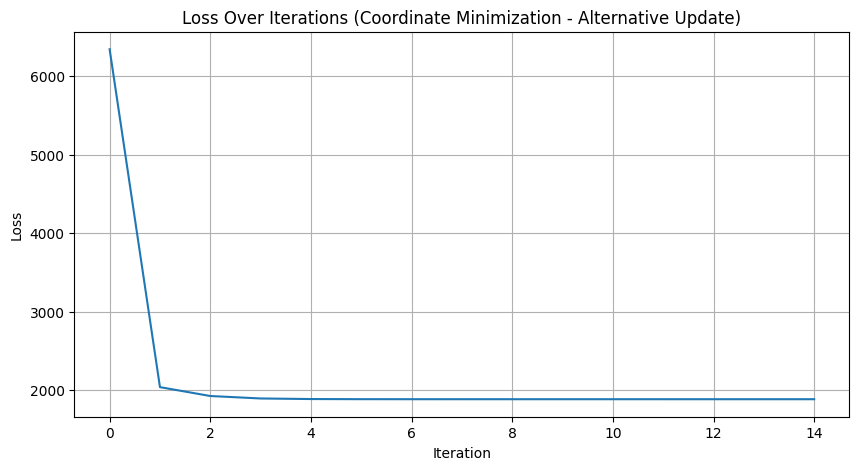

In [ ]:
np.random.seed(77)

#Coordinate Minimization GD (sequantial order Gauss-Seidel)

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, squareform, pdist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score

# --- Data Loading and Preprocessing ---
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Use a fixed random state for reproducibility
X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(
    X, y, test_size=0.8, stratify=y
)

L = len(X_labeled)
U = len(X_unlabeled)

labeled_coords = X_labeled[:, :]
unlabeled_coords = X_unlabeled[:, :]

# --- Weight Calculation (W and W_hat remain as in your original code) ---
W = cdist(labeled_coords, unlabeled_coords, metric='euclidean')
W_hat = squareform(pdist(unlabeled_coords, metric='euclidean'))
epsilon = 1e-8
W = 1 / (W + epsilon)
W_hat = 1 / (W_hat + epsilon)

# --- Optimization (Coordinate Minimization with modified update) ---
y_unlabeled = np.random.rand(U)
y_labeled = y_labeled.astype(float) # Ensure labeled data is float

max_iter = 500 # Maximum number of outer iterations (cycles through all coordinates)
tolerance = 1e-5 # Stopping condition: stop if change in y_unlabeled is small

loss_history = []
y_unlabeled_history = [y_unlabeled.copy()] # Track y_unlabeled for convergence check
start_time = time.process_time()
print("Starting Coordinate Minimization (Alternative Update)...")

for iteration in range(max_iter):
    y_unlabeled_old = y_unlabeled.copy()

    # Compute current loss before the cycle of updates
    # The loss calculation is correct even with the large W_hat diagonal
    current_loss = loss_function(W, W_hat, y_labeled, y_unlabeled)
    loss_history.append(current_loss)

    # --- Cycle through each unlabeled coordinate (y_unlabeled[j]) ---
    for j in range(U):
        sum_W_hat_ju_except_j = np.sum(W_hat[j, :] * y_unlabeled) - W_hat[j, j] * y_unlabeled[j]
        sum_W_hat_j_except_j = np.sum(W_hat[j, :]) - W_hat[j, j]

        numerator = 2*np.sum(W[:, j] * y_labeled) + sum_W_hat_ju_except_j
        denominator = 2*np.sum(W[:, j]) + sum_W_hat_j_except_j

        if denominator > epsilon:
             y_unlabeled[j] = numerator / denominator

    # Calculate the maximum absolute change in y_unlabeled across this iteration's cycle
    max_change = np.max(np.abs(y_unlabeled - y_unlabeled_old))
    y_unlabeled_history.append(y_unlabeled.copy()) # Store updated y_unlabeled

    if max_change < tolerance:
        print(f"Converged at iteration {iteration} with max change {max_change:.6f}")
        break

    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {current_loss:.4f}, Max Change: {max_change:.6f}")

if iteration == max_iter - 1:
    print(f"Maximum iterations ({max_iter}) reached.")

end_time = time.process_time()
cpu_time = end_time - start_time
print("\nOptimization finished.")
print("Final y_unlabeled values:")


y_pred = (y_unlabeled > 0.7).astype(int)
print(y_unlabeled)
# Evaluate accuracy on the true unlabeled labels
accuracy = accuracy_score(y_unlabeled_true, y_pred)
print(f"\nAccuracy on unlabeled data: {accuracy:.4f}")
print(f"CPU time for Coordinate Minimization (Alternative Update): {cpu_time:.2f} seconds")
print("Predicted labels (first 20):", y_pred[:20])
print("True unlabeled labels (first 20):", y_unlabeled_true[:20])


# --- Plotting ---
# Plot the loss over iterations
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Loss Over Iterations (Coordinate Minimization - Alternative Update)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()